In [1]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import pickle
from timeit import timeit
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [2]:
se.set_style("darkgrid")

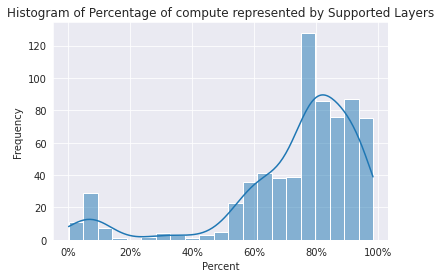

In [3]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

plt = se.histplot(x = arch_metrics["percent_of_compute"].groupby(level=0).sum().multiply(100), kde=True)
plt.set_title('Histogram of Percentage of compute represented by Supported Layers')
plt.set_xlabel('Percent')
plt.set_ylabel('Frequency')
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
# present as CDF and Histogram

524.4844275056896

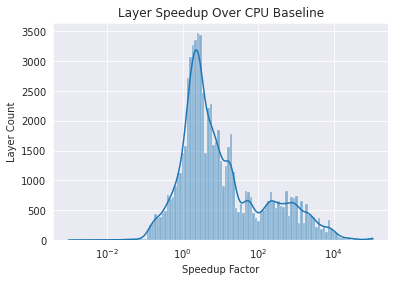

In [4]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
x = arch_metrics['speedup']
plt = se.histplot(x, log_scale=True, kde=True)
plt.set_xscale('log', base=10)
plt.set_xlabel('Speedup Factor')
plt.set_ylabel('Layer Count')
plt.set_title('Layer Speedup Over CPU Baseline')
arch_metrics['speedup'].mean()

FPS    333.949554
dtype: float64

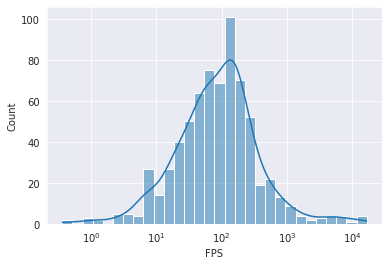

In [5]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

fps = arch_metrics.groupby(level = 0).sum().loc[:, arch_metrics.columns.isin(['latency'])].mul(1*10**-9).pow(-1)
fps = fps.rename(columns={"latency": "FPS"})
plt = se.histplot(data = fps, x = "FPS", kde=True, log_scale=True)
fps.mean()

/tmp/ipykernel_196954/3730001291.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_196954/3730001291.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_y.set_yticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_y.get_yticks()])


Text(0.5, -0.2, 'Scatter Plot of PE Utilization vs MAC Operations')

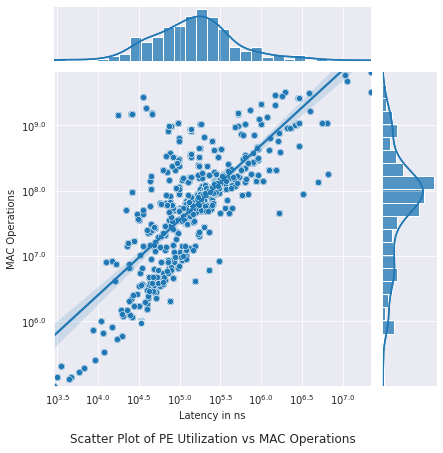

In [6]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0,1],)

latency = pd.DataFrame(np.log10(arch_metrics["latency"].groupby(level=0).mean()).copy())
macs = pd.DataFrame(np.log10(layer_metrics["macs"].groupby(level=0).mean()).copy())
latency_vs_mac_df = latency.join(macs)

plt = se.jointplot(
    data=latency_vs_mac_df,
    x="latency",
    y="macs",
    kind="reg",
    # cmap="Blues",
    # zorder=2,
    # levels=10,
    # alpha=0.9,
    # shade=True,
    # thresh=0,
    ylim=(
        latency_vs_mac_df[["macs"]].min().item(),
        latency_vs_mac_df[["macs"]].max().item(),
    ),
    xlim=(
        latency_vs_mac_df[["latency"]].min().item(),
        latency_vs_mac_df[["latency"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_marg_y.set_yticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_y.get_yticks()])
plt.ax_joint.set_ylabel('MAC Operations')
plt.ax_joint.set_xlabel('Latency in ns')
plt.ax_joint.set_title('Scatter Plot of PE Utilization vs MAC Operations', y = -0.2)


6.766360497533579

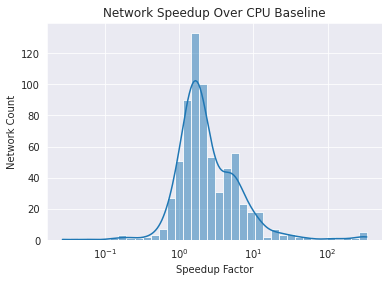

In [7]:
layer_metrics = pd.read_csv(
    "../data/layer_metrics.csv",
    index_col=[0, 1],
)
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)

network_speedup = (
    layer_metrics["cpu_time"].groupby(level=0).sum().mul(10**3)
    / arch_metrics["latency"].groupby(level=0).sum()
)
plt = se.histplot(network_speedup, log_scale=True, kde=True)
plt.set_xscale('log', base=10)
plt.set_xlabel('Speedup Factor')
plt.set_ylabel('Network Count')
plt.set_title('Network Speedup Over CPU Baseline')
network_speedup.mean()

29.944583089925093

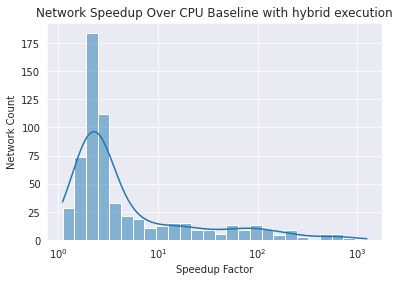

In [8]:
layer_metrics = pd.read_csv(
    "../data/layer_metrics.csv",
    index_col=[0, 1],
)
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)

cpu_baseline = layer_metrics["cpu_time"].groupby(level=0).sum().mul(10**3)
latency_of_spedup_layers = arch_metrics[arch_metrics['speedup']>1]['latency'].groupby(level=0).sum()
latency_of_offloaded_layers = arch_metrics.join(layer_metrics)[arch_metrics['speedup']<=1]['cpu_time'].mul(10**3).groupby(level=0).sum()
network_speedup = cpu_baseline/(latency_of_offloaded_layers+latency_of_spedup_layers)
plt = se.histplot(network_speedup, log_scale=True, kde=True)
plt.set_xscale('log', base=10)
plt.set_xlabel('Speedup Factor')
plt.set_ylabel('Network Count')
plt.set_title('Network Speedup Over CPU Baseline with hybrid execution')
network_speedup.mean()
# arch_metrics[arch_metrics['speedup']>1]['latency'] + arch_metrics[arch_metrics['speedup']<=1].join(layer_metrics)['cpu_time']

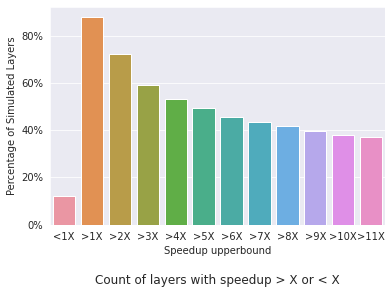

In [9]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
total = len(arch_metrics)
labels = []
values = []

labels.append(f'<1X')
values.append(len(arch_metrics[arch_metrics["speedup"] < 1]) / total * 100)

for ub_speedup in (range(1, 12)):
    labels.append(f'>{ub_speedup}X')
    values.append(len(arch_metrics[arch_metrics["speedup"] > ub_speedup]) / total * 100)
    
counts = pd.DataFrame(
    {
        "Speedup upperbound": labels,
        "Percentage of Simulated Layers": values,
    }
)
plt = se.barplot(data=counts, x="Speedup upperbound", y="Percentage of Simulated Layers")
plt.set_title("Count of layers with speedup > X or < X", y=-0.3)
plt.yaxis.set_major_formatter(mtick.PercentFormatter())
